In [27]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *

In [28]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are
figure_folder = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_figures'
subjects_to_process = ['06']
period = 'pre'

In [29]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)
ch_names_64 = ch_names_all[0:64]
ch_names_72 = ch_names_all[0:72]

downfreq = 128

for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_listen_{period}_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    all_electrodes = data['all_electrodes']
    events_sv = data['events']

Opening eeg_listen_pre_06.mat


In [30]:
 #making raw object from .mat data
info = mne.create_info(ch_names=ch_names_72, sfreq = 128, ch_types='misc')
raw = mne.io.RawArray(all_electrodes, info = info)

#define channel types
raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})


Creating RawArray with float64 data, n_channels=72, n_times=85120
    Range : 0 ... 85119 =      0.000 ...   664.992 secs
Ready.


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_45762/466707695.py:6: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FCz, FT7, FT8, Fp1, Fp2, Fpz, Fz, Iz, O1, O2, Oz, P1, P10, P2, P3, P4, P5, P6, P7, P8, P9, PO3, PO4, PO7, PO8, POz, Pz, T7, T8, TP7, TP8 has changed from NA to V.
  raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_45762/466707695.py:7: RuntimeWarning: The unit for channel(s) LO1, LO2 has changed from NA to V.
  raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})


<RawArray | 72 x 85120 (665.0 s), ~46.8 MB, data loaded>

In [31]:
raw.set_montage('biosemi64')

<RawArray | 72 x 85120 (665.0 s), ~46.8 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


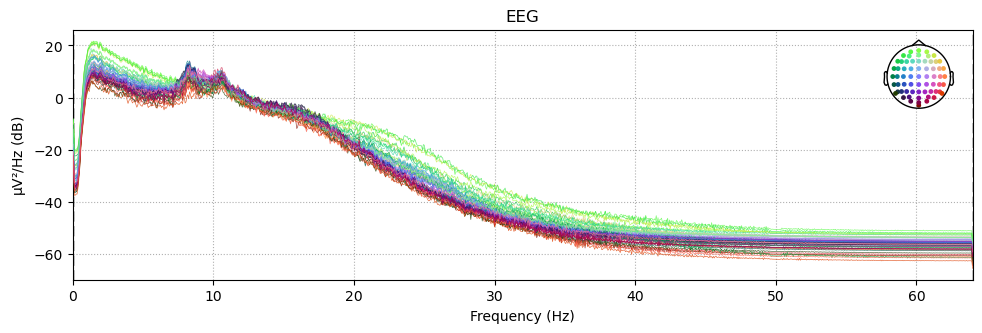

In [32]:
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)

## ICA

In [33]:
ica = ICA(max_iter="auto", random_state=97)
ica.fit(raw)

#exclude components
eog_indices, eog_scores = ica.find_bads_eog(raw)

ica.exclude = eog_indices
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_45762/3661858401.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 64 components


KeyboardInterrupt: 

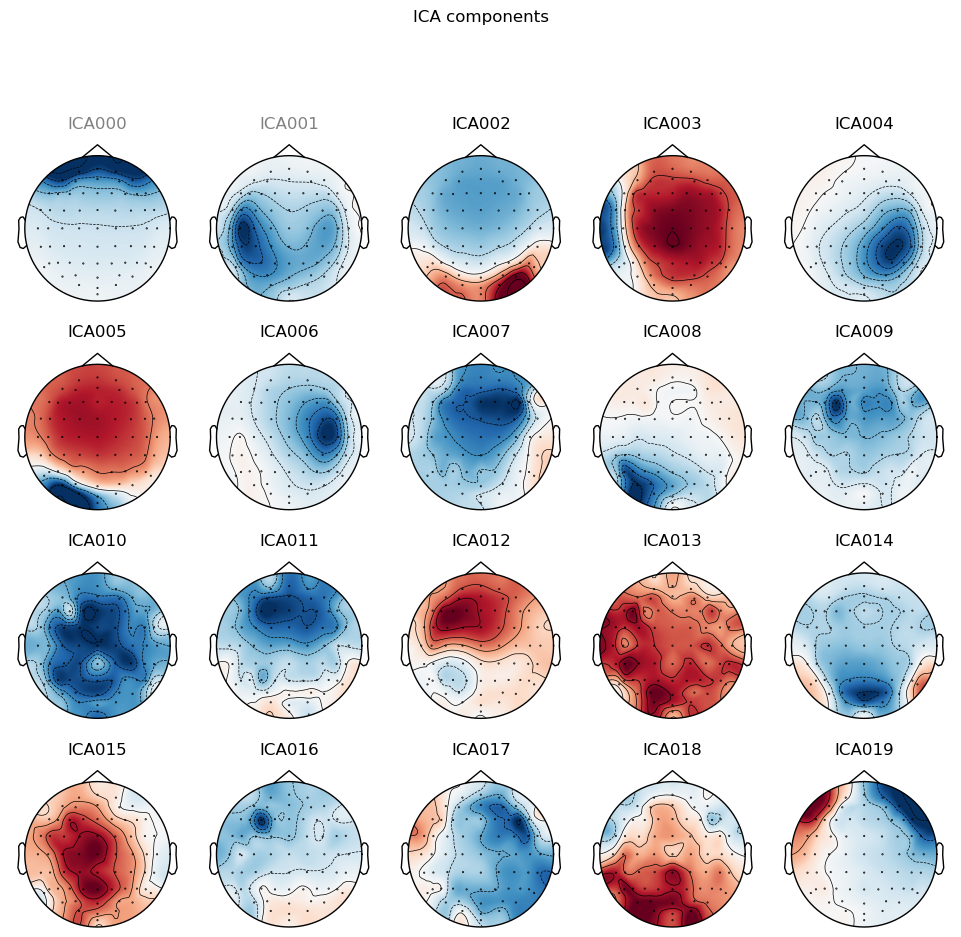

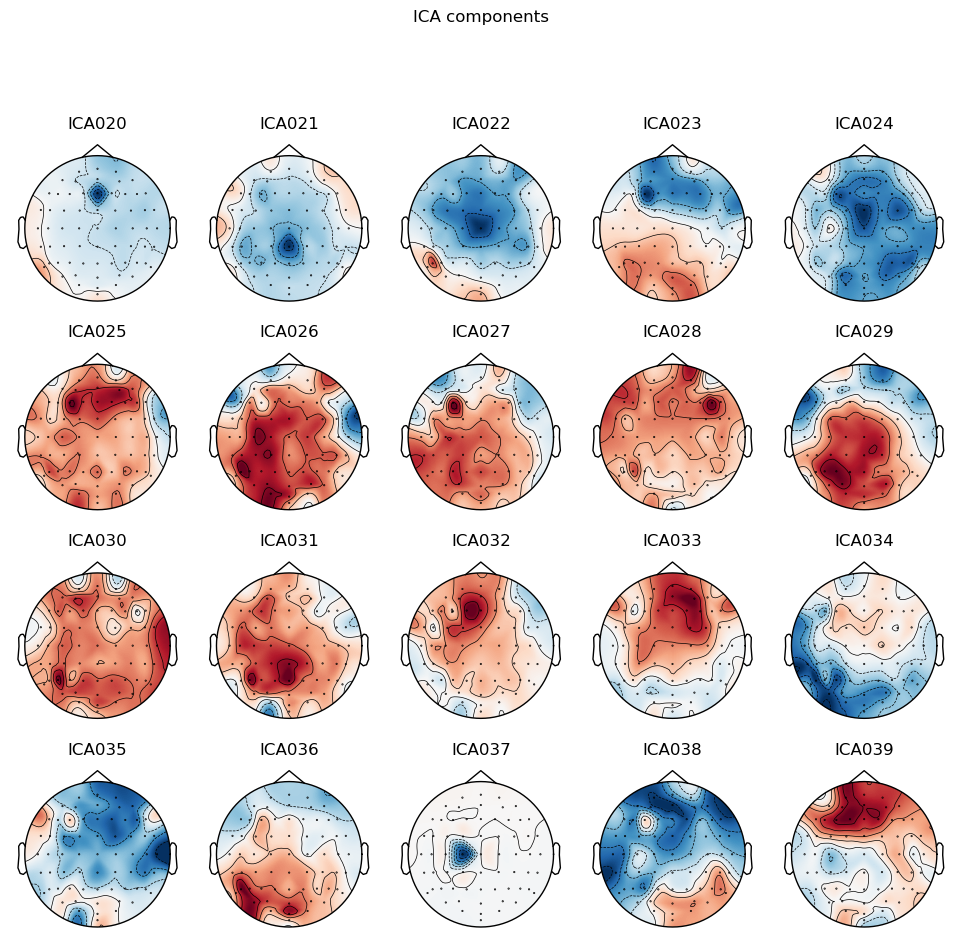

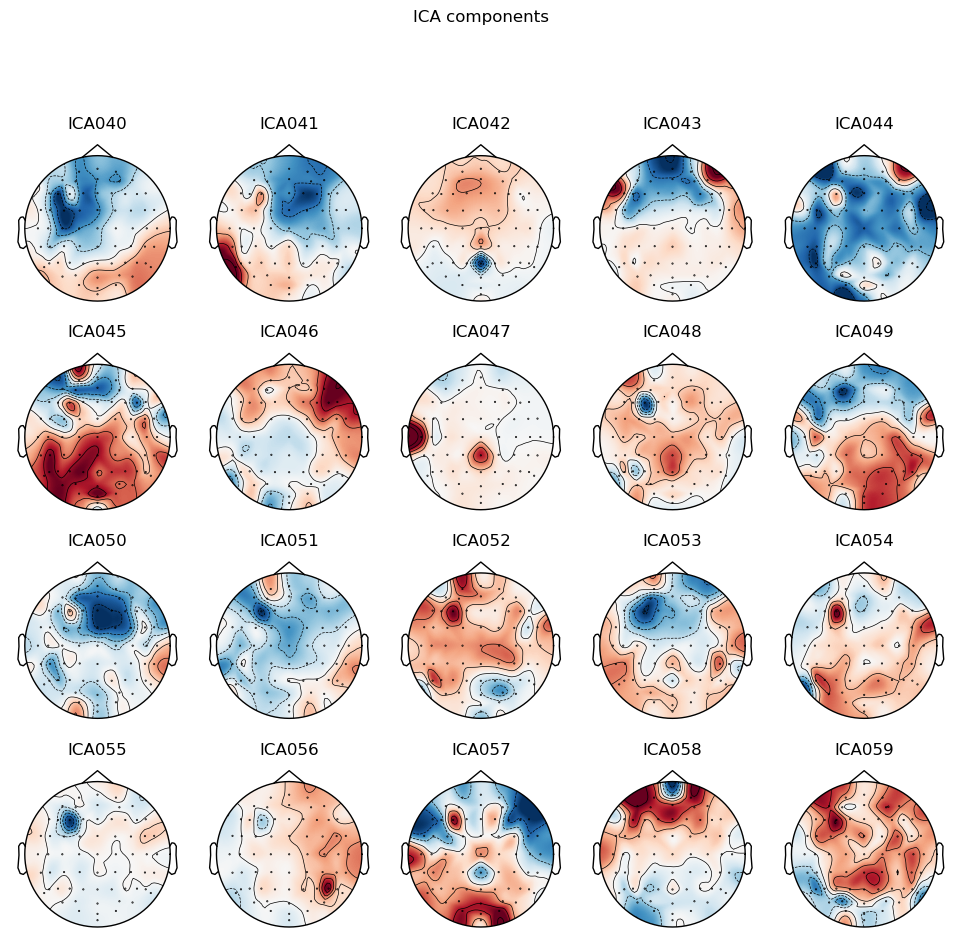

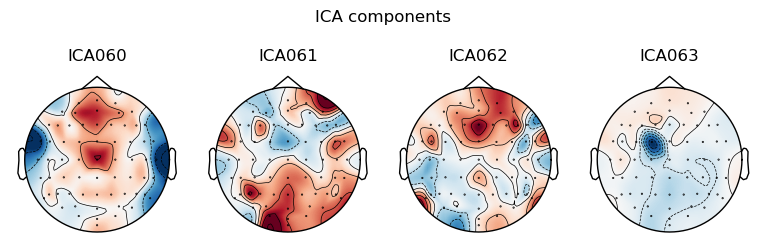

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>]

In [ ]:
ica.plot_components()

In [ ]:
eeg_ica = reconst_raw.get_data()
eeg_ica[0:64].shape


(64, 85120)

In [ ]:
savemat(f'eeg_ICA_{subject_ID}_{period}.mat', {'trial_data': eeg_ica[0:64], 'events': events_sv})

## PLOTS

All keystroke ERPs

In [ ]:
events_arr = make_raw_events(events_sv)
t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])

Not setting metadata
328 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 328 events and 154 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


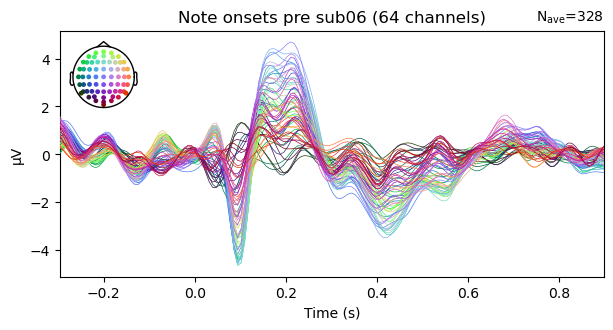

In [ ]:
epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=-0.3, tmax=0.9, preload=True)
#fig = epochs.plot(events=t_keystrokes)
evoked = epochs.average()
fig = evoked.plot(titles = f'Note onsets {period} sub{subject_ID}')
fig.savefig(f'{figure_folder}/{subject_ID}_listen_{period}.png')

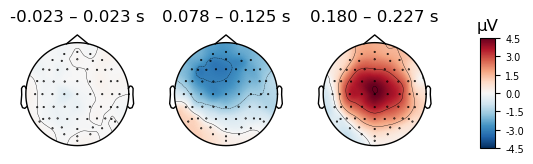

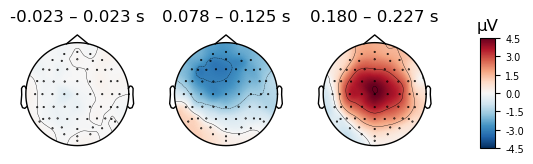

In [ ]:
evoked.plot_topomap(times=[0,0.1, 0.2], average=0.05)

combining channels using "mean"


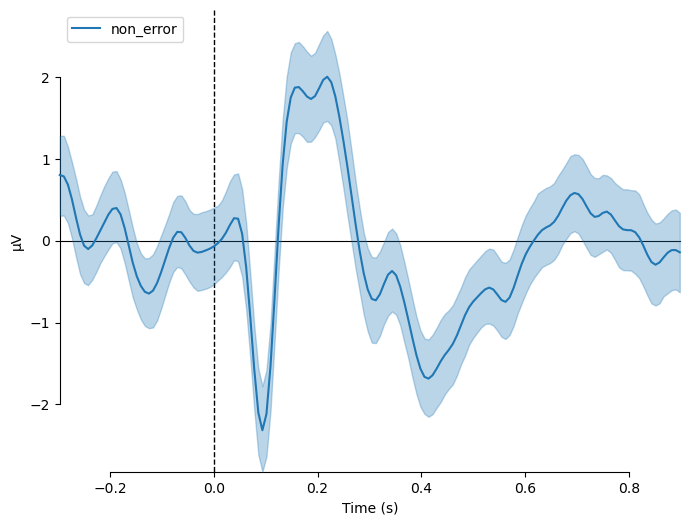

[<Figure size 800x600 with 1 Axes>]

In [ ]:
t_evokeds = dict(
        #cue=list(epochs['cue'].iter_evoked()),
        non_error=list(epochs.iter_evoked()))
mne.viz.plot_compare_evokeds(t_evokeds, combine = 'mean')

In [ ]:
epochs.save('ep_test.fif')

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_45762/4151979350.py:1: RuntimeWarning: This filename (ep_test.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save('ep_test.fif')


In [ ]:
epochs.save('ep_test2.fif')

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_45762/755909550.py:1: RuntimeWarning: This filename (ep_test2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save('ep_test2.fif')


In [ ]:
new_epochs = mne.read_epochs('ep_test.fif')
new_epochs_2 = mne.read_epochs('ep_test2.fif')
comb_eps = mne.concatenate_epochs([new_epochs, new_epochs_2, new_epochs_2])

Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/ep_test.fif ...
    Found the data of interest:
        t =    -296.88 ...     898.44 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/ep_test2.fif ...
    Found the data of interest:
        t =    -296.88 ...     898.44 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
984 matching events found
Applying baseline correction (mode: mean)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_45762/488490476.py:1: RuntimeWarning: This filename (ep_test.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  new_epochs = mne.read_epochs('ep_test.fif')
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_45762/488490476.py:2: RuntimeWarning: This filename (ep_test2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  new_epochs_2 = mne.read_epochs('ep_test2.fif')


combining channels using "mean"


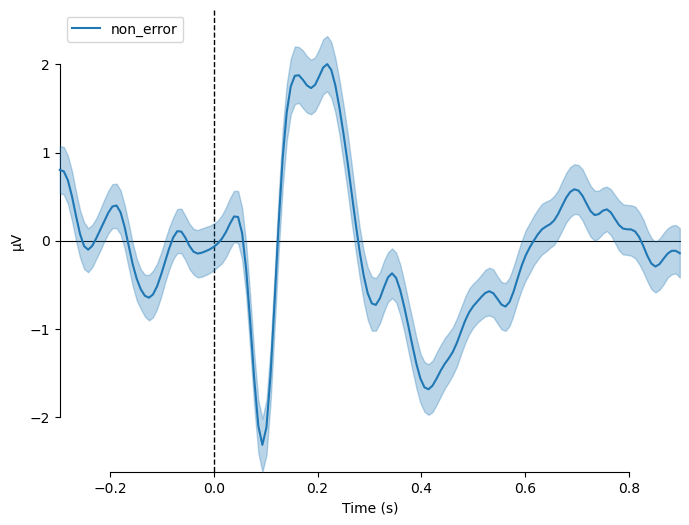

[<Figure size 800x600 with 1 Axes>]

In [ ]:
comb_evokeds = dict(
        #cue=list(epochs['cue'].iter_evoked()),
        non_error=list(comb_eps.iter_evoked()))
mne.viz.plot_compare_evokeds(comb_evokeds, combine = 'mean')